In [3]:
from qiskit import* 
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

%matplotlib inline

IBMQ.load_account()

provider=IBMQ.get_provider('ibm-q')

simulator=Aer.get_backend('qasm_simulator')

In [29]:
from typing import *
import math

class circuitBuilder(object):
    def __init__(self,minCiruitsize:Tuple[int,int],builder:Callable[[QuantumCircuit,Any],QuantumCircuit],stateValidator:Callable[[Any],bool] = lambda s: True,state = None):
        self._builder = builder
        self._validator = stateValidator
        self.minCiruitsize = minCiruitsize

        if self.isValidState(state):
            self._state = state
        else:
            raise TypeError(f"Invalide state {state}")
        
    def __call__(self,circuit:QuantumCircuit) -> QuantumCircuit:
        return self._builder(circuit,self._state)
    
    def setState(self,state:Any):
        if self.isValidState(state):
            self._state = state
        else :
            raise TypeError(f"Invalide state {state}")
        
    def isValidState(self,state:Any) -> bool:
        return self._validator(state)

class Qubit(object):
    def __init__(self,c1:complex,c2:complex):
        if not math.isclose(abs(c1)**2+abs(c2)**2, 1):
            raise ValueError(f"Invalid Qubit state {c1}|0> + {c2}|1> sum of amplitudes-squared does not equal one. ")
        self.c1 = c1
        self.c2 = c2

    def QubitValidator(s:Any) -> bool:
        return isinstance(s,Qubit)

    def toVector(self)->list:
        return [self.c1,self.c2]
    
    def __str__(self) -> str:
        return f"[{self.c1};{self.c2}]"

def teleportBuilder(circuit:QuantumCircuit,state:Qubit)->QuantumCircuit:

    circuit.initialize(state.toVector(),0)

    circuit.h(1)
    circuit.cnot(1,2)
    
    circuit.barrier()

    circuit.cnot(0,1)
    circuit.h(0)

    circuit.barrier()

    circuit.cnot(1,2)
    circuit.cz(0,2)

    circuit.barrier()

    circuit.measure(2,0)

    return circuit

In [30]:
import time
from qiskit.providers.ibmq import *
import matplotlib.pyplot as plt

def autoSelectQComputer(filter:"list[str]",builder:circuitBuilder,states:list,maxQueuedJob:int = 10) -> IBMQBackend:
    provider=IBMQ.get_provider('ibm-q')
    simulator=Aer.get_backend('qasm_simulator')

    filter = filter.copy()

    for f in filter:
        qcomputer = provider.get_backend(f)
        if qcomputer.status().pending_jobs > maxQueuedJob:
            filter.remove(f)
            continue
        joblim = qcomputer.job_limit()
        if joblim.maximum_jobs - joblim.active_jobs > len(states):
            print(f"[Warning] number of states is superior to the number of available jobs for the backend {f} autoselection may take longer than expected")

    jobs = {s:{n:{"job":None,"expeResult":None,"status":None} for n in filter} for s in states}

    for s in states:
        builder.setState(s)
        circuit = QuantumCircuit(*builder.minCiruitsize)
        circuit = builder(circuit)
        counts = execute(circuit,backend = simulator,shots=512).result().get_counts()
        jobs[s]["simResult"] = {k:counts[k] for k in counts}

        for f in filter:
            qcomputer = provider.get_backend(f)
            while (True):
                joblim = qcomputer.job_limit()
                if joblim.maximum_jobs - joblim.active_jobs >=1:
                    break
                time.sleep(2)
            jobs[s][f]["job"] = execute(circuit,backend = qcomputer,shots=512)
            print(f"{str(s)} started for {f}")
        
    jobsLeft = len(states)*len(filter)

    while jobsLeft >0:
        time.sleep(10)
        for s in states:
            for f in filter:
                if jobs[s][f]["status"] != None :
                    continue
                status = jobs[s][f]["job"].status()
                if (status.name in ['DONE', 'CANCELLED', 'ERROR']):
                    jobsLeft -= 1

                    if status.name == 'ERROR':
                        print(f"An error occured while processing state {s} on {f}")
                    
                    if status.name == 'DONE':
                        counts = jobs[s][f]["job"].result().get_counts()
                        plt.figure()
                        
                        jobs[s][f]["expeResult"] = {k:counts[k] for k in counts}
                        
                        plt.bar(jobs[s][f]["expeResult"].keys(),jobs[s][f]["expeResult"].values())
                        plt.title(f"{str(s)} on {f}")

                    jobs[s][f]["status"] = status.name
                    print(f"{str(s)} ended for {f}")

    errors = {f:{"count":0,"tot":0} for f in filter}

    for s in states:
        for f in filter:
            if jobs[s][f]["status"] == 'DONE':
                errors[f]["tot"] += 512
                for k in jobs[s]["simResult"].keys():
                    errors[f]["count"] += abs(jobs[s][f]["expeResult"][k] - jobs[s]["simResult"][k])
    
    back = None
    error = 2.0

    for (k,v) in errors.items() :
        e = float(v["count"])/v["tot"]
        if e<error:
            error = e
            back = k
    
    print(error)
    print(back)
    plt.plot()
    return provider.get_backend(back)

[Warning] number of states is superior to the number of available jobs for the backend ibmq_athens autoselection may take longer than expected
[Warning] number of states is superior to the number of available jobs for the backend ibmq_belem autoselection may take longer than expected
[Warning] number of states is superior to the number of available jobs for the backend ibmq_quito autoselection may take longer than expected
[1;0] started for ibmq_santiago
[1;0] started for ibmq_athens
[1;0] started for ibmq_belem
[1;0] started for ibmq_quito
[1;0] started for ibmqx2
[0;1] started for ibmq_santiago
[0;1] started for ibmq_athens
[0;1] started for ibmq_belem
[0;1] started for ibmq_quito
[0;1] started for ibmqx2
[1;0] ended for ibmq_belem
[1;0] ended for ibmqx2
[0;1] ended for ibmq_belem
[0;1] ended for ibmqx2
[1;0] ended for ibmq_santiago
[0;1] ended for ibmq_santiago
[1;0] ended for ibmq_athens
[0;1] ended for ibmq_athens
[1;0] ended for ibmq_quito
[0;1] ended for ibmq_quito
0.0322265625


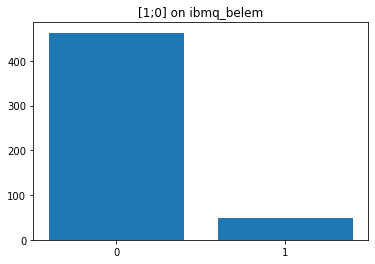

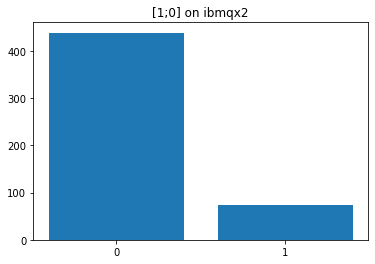

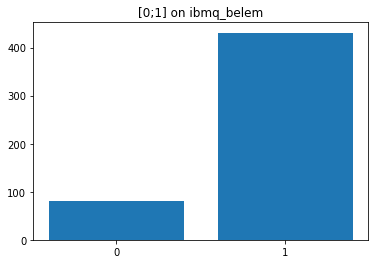

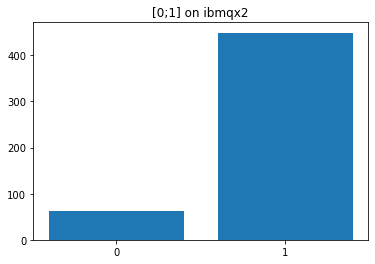

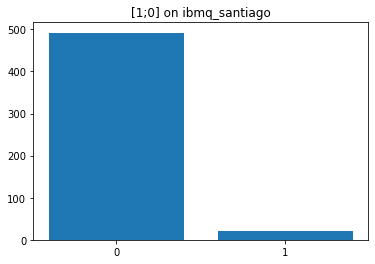

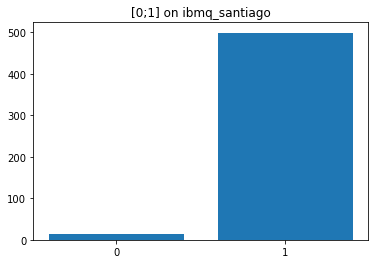

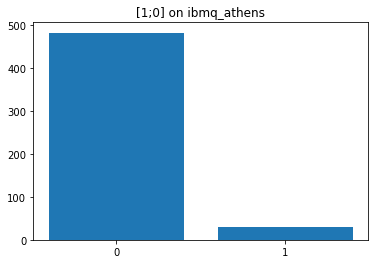

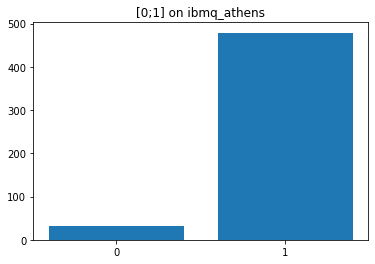

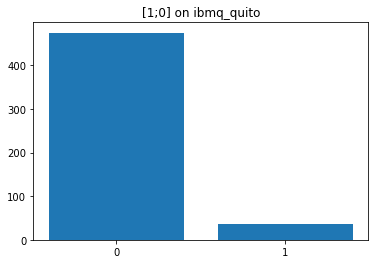

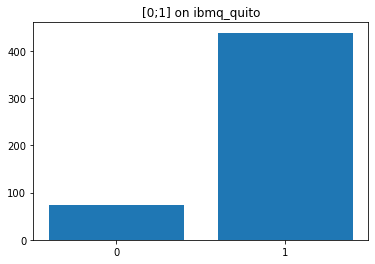

In [32]:
proco = ["ibmq_manila","ibmq_santiago","ibmq_athens","ibmq_belem","ibmq_quito","ibmq_lima","ibmqx2"]

qcomputer = autoSelectQComputer(proco, circuitBuilder((3,1),teleportBuilder,Qubit.QubitValidator,Qubit(0,1)), [Qubit(1,0),Qubit(0,1)] )


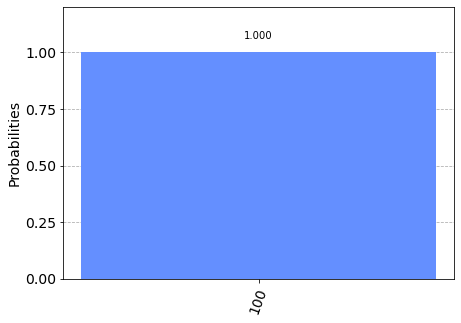

In [39]:
result=execute(tcircuit,backend = simulator,shots=1024).result()
counts=result.get_counts()

plot_histogram(counts)

In [17]:
class Binary(object):
    def __init__(self,binary):
        self.binary = str(binary)
        if not Binary.isBinary(self.binary):
            raise TypeError(self.binary + "is not a binary number")
        
    def isBinary(binary:str):
        for i in range(len(binary)):
            if binary[i] != "1" and binary[i] != "0":
                return False
        return True
    
    def __getitem__(self, name: int) -> int:
        return int(self.binary[len(self.binary) - name-1])
    
    def __len__(self) -> int:
        return len(self.binary)
    
    def __str__(self) -> str:
        return self.binary

In [32]:
def toBCounts(counts):
    return {Binary(k):counts[k] for k in counts}

def getError(ccounts,expected):
    E=0.0
    T=0
    for k,v in ccounts.items():
        T += v
        if k[2] !=  expected :
            E += v
    return E/T

print(getError(BCounts,0))
       

0.0


In [42]:


jobs = []

vals = []

for p in proco:
    jobs.append((p,execute(tcircuit,backend = provider.get_backend(p),shots=512)))

In [44]:
for j in jobs :
    print(j[0])
    job_monitor(j[1])
    vals.append((j[0],getError(toBCounts(j[1].result().get_counts()),1)))

vals.sort(key=lambda c:c[1])

ibmq_manila
Job Status: job has successfully run
ibmq_santiago
Job Status: job has successfully run
ibmq_athens
Job Status: job has successfully run
ibmq_belem
Job Status: job has successfully run
ibmq_quito
Job Status: job has successfully run
ibmq_lima
Job Status: job is queued (33)

KeyboardInterrupt: 

In [45]:
vals.sort(key=lambda c:c[1])
print(vals)

[('ibmq_belem', 0.861328125), ('ibmq_quito', 0.873046875), ('ibmq_manila', 0.90234375), ('ibmq_athens', 0.9296875), ('ibmq_santiago', 0.94140625)]


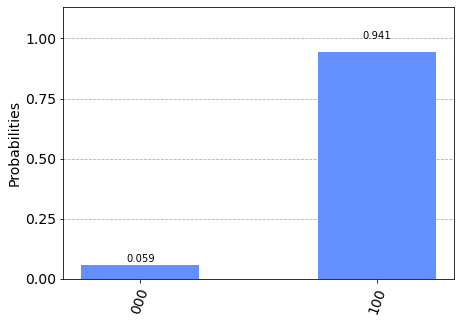

In [48]:
p=None
for j in jobs :
    if (j[0] == 'ibmq_santiago'):
        p=plot_histogram(j[1].result().get_counts())
p